# Feature Engineering with custom Keras Feature Layers for complete training pipeline.

This example is similar to the lambda_layer_engineering.ipynb notebook. But there we will implement custom layers by subclassing Keras Layer class.

Often for structured data problems we end up using multiple libraries for preprocessing or feature engineering. We can go as far as having a full ML training pipeline using different libraries for example Pandas for reading data and also feature engineeering, sklearn for encoding features for example OneHot encoding and Normalization. The estimator might be an sklearn classifier, xgboost or it can for example be a Keras model. In the latter case, we would end up with artifacts for feature engineering and encoding and also different artifacts for the saved model. The pipeline is also disconnected and an extra step is needed to feed encoded data to the Keras model. For this step the data can be mapped from a dataframe to something like tf.data.Datasets type or numpy array before feeding it to a Keras model.

In this post we will consider implementing a training pipeline natively with Keras/Tensorflow. From loading data with tf.data. As the the title suggested we will use Lambda layers for feature engineering. These engineered features will be stateless. For stateful preprocessing we could use something like Keras preprocessing layers. We will end up with a training pipeline where feature engineering will be part of the network architecture and can be persisted and loaded for inference as standalone.

Keep in mind that tf.keras.layers.Lambda layers have (de)serialization limitations because Lambda layers are saved by serializing the python bytecode.

Steps we will follow:
- Load data with tf.data
- Create Input layer
- Implementing custom feature layers
- Train model

# Example

For the example below we will use the heart disease dataset. Lets import tensorflow and read in the data:

In [1]:
import tensorflow as tf
from keras.utils.vis_utils import plot_model

In [2]:
heart_dir = tf.keras.utils.get_file(
    "heart.csv", origin="http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
)

dataset = tf.data.experimental.make_csv_dataset(
      heart_dir,
      batch_size=64,
      label_name='target',
      num_epochs=10
)

In [3]:
binary_features = ['sex', 'fbs', 'exang']
numeric_features =  ['trestbps', 'chol', 'thalach', 'oldpeak', 'slope', 'cp', 'restecg', 'ca']
categoric_features = ['thal']

dtype_mapper = {
        'age': tf.float32,
        'sex': tf.float32,
        'cp': tf.float32,
        'trestbps': tf.float32,
        'chol': tf.float32,
        'fbs': tf.float32,
        'restecg': tf.float32,
        'thalach': tf.float32,
        'exang': tf.float32,
        'oldpeak': tf.float32,
        'slope': tf.float32,
        'ca': tf.float32,
        'thal': tf.string
}


## Create Input Layer

In [4]:
def create_inputs(data_type_mapper):
    """Create model inputs
    Args:
        data_type_mapper (dict): Dictionary with feature as key and dtype as value
                                 For example {'age': tf.float32, ...}
    Returns:
        (dict): Keras inputs for each feature
    """
    return {feature: tf.keras.Input(shape=(1,), name=feature, dtype=dtype)\
        for feature, dtype in data_type_mapper.items()}

feature_layer_inputs = create_inputs(dtype_mapper)

In [5]:
feature_layer_inputs['age']

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'age')>

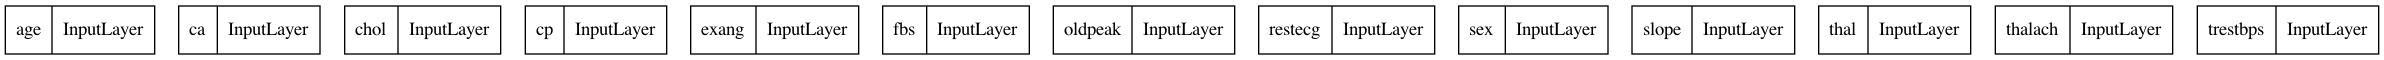

In [6]:
input_layer_graph = tf.keras.Model(inputs=feature_layer_inputs, outputs=feature_layer_inputs)
plot_model(input_layer_graph, to_file="input_layer.png")

## Implement custom layers for Feature Engineering

In [14]:
class AgeAndGenderFeatureLayer(tf.keras.layers.Layer):
    """Feature that checks if age and gender condition holds
    """
    def __init__(self, *args, **kwargs):
        super(AgeAndGenderFeatureLayer, self).__init__(trainable=False, *args, **kwargs)
    
    def call(self, inputs):
        age, gender = inputs
        return tf.cast(
            tf.math.logical_and(age > 50, gender == 1), dtype = tf.float32
        )


class CategoricEncodingFeatureLayer(tf.keras.layers.Layer):
    """One hot encoding Thal categoric feature
    """
    def __init__(self, category_value=None, *args, **kwargs):
        super(CategoricEncodingFeatureLayer, self).__init__(trainable=False, *args, **kwargs)
        self.category_value = category_value
    
    def call(self, thal):
        return tf.cast(thal == self.category_value, dtype = tf.float32)


class RatioFeatureLayer(tf.keras.layers.Layer):
    """Ratio between features
    """
    def __init__(self, *args, **kwargs):
        super(RatioFeatureLayer, self).__init__(trainable=False, *args, **kwargs)
    
    def call(self, inputs):
        feature_layer_a, feature_layer_b = inputs
        return feature_layer_a / feature_layer_b


class CrossingFeatureLayer(tf.keras.layers.Layer):
    """Crossing between features
    """
    def __init__(self, *args, **kwargs):
        super(CrossingFeatureLayer, self).__init__(trainable=False, *args, **kwargs)
    
    def call(self, inputs):
        feature_layer_a, feature_layer_b = inputs
        return feature_layer_a * feature_layer_b

## Engineered Features: Custom functions for Lambda Layers

### Now that we have our custom functions lets create the features as Lambda layers:

In [19]:
thal_fixed_category = CategoricEncodingFeatureLayer(name='thal_fixed_category', category_value='fixed')(
    feature_layer_inputs['thal']
)

thal_reversible_category = CategoricEncodingFeatureLayer(name='thal_reversible_category', category_value='reversible')(
    feature_layer_inputs['thal']
)

thal_normal_category = CategoricEncodingFeatureLayer(name='thal_normal_category', category_value='normal')(
    feature_layer_inputs['thal']
)

age_and_gender = AgeAndGenderFeatureLayer(name='age_and_gender')(
    (feature_layer_inputs['age'], feature_layer_inputs['sex'])
)

trest_chol_ratio = RatioFeatureLayer(name='trest_chol_ratio')(
   (feature_layer_inputs['trestbps'], feature_layer_inputs['chol'])
)

trest_cross_thalach = CrossingFeatureLayer(name='trest_cross_thalach')(
   (feature_layer_inputs['trestbps'], feature_layer_inputs['thalach'])
)

# concat all newly created features into one layer
feature_list = [thal_fixed_category, thal_reversible_category, thal_normal_category,
                age_and_gender, trest_chol_ratio, trest_cross_thalach]

engineered_feature_layer = tf.keras.layers.concatenate(feature_list, name='engineered_feature_layer')

# Visualize Feature Layer

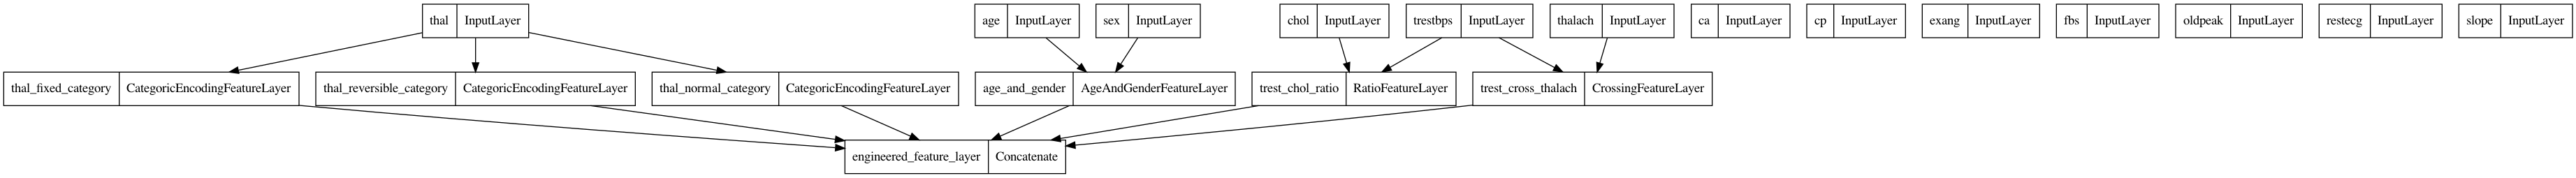

In [20]:
feature_graph = tf.keras.Model(inputs=feature_layer_inputs, outputs=engineered_feature_layer)
plot_model(feature_graph, to_file="engineered_feature_layer.png")

## All our engineered feature layers are created and we can now combine it with our other features

In [21]:
numeric_feature_layer = tf.keras.layers.concatenate(
    [feature_layer_inputs[feature] for feature in numeric_features], name='numeric_feature_layer'
)

binary_feature_layer = tf.keras.layers.concatenate(
    [feature_layer_inputs[feature] for feature in binary_features], name='binary_feature_layer'
)

# Add the rest of features
feature_layer = tf.keras.layers.concatenate(
    [engineered_feature_layer, numeric_feature_layer, binary_feature_layer], name='feature_layer'
)

# Visualize full Feature Layer

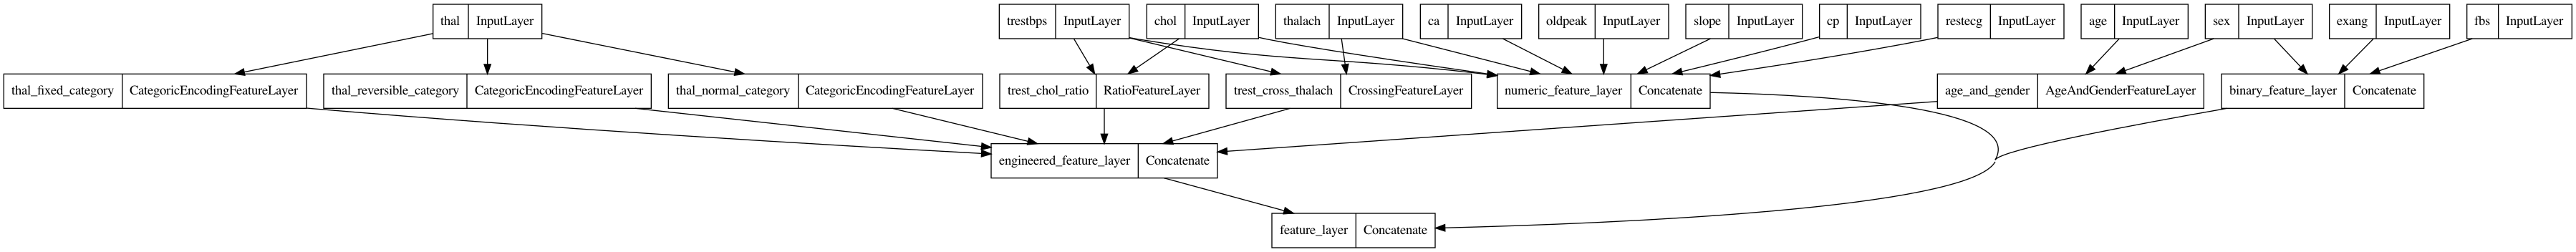

In [22]:
full_feature_graph = tf.keras.Model(inputs=feature_layer_inputs, outputs=feature_layer)
plot_model(full_feature_graph, to_file="complete_feature_layer.png")

## Our last step is to create and fit our Keras model. For this example we will use a simple model architecture. We will persist the model and load it for inference.

In [23]:
# setup model, this is basically Logistic regression
x = tf.keras.layers.BatchNormalization(name='batch_norm')(feature_layer)
output = tf.keras.layers.Dense(1, activation='sigmoid', name='target')(x)
model = tf.keras.Model(inputs=feature_layer_inputs, outputs=output)
model.compile(
  loss=tf.keras.losses.BinaryCrossentropy(),
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'), 
           tf.keras.metrics.AUC(name='auc')]
)

# Visualize full network

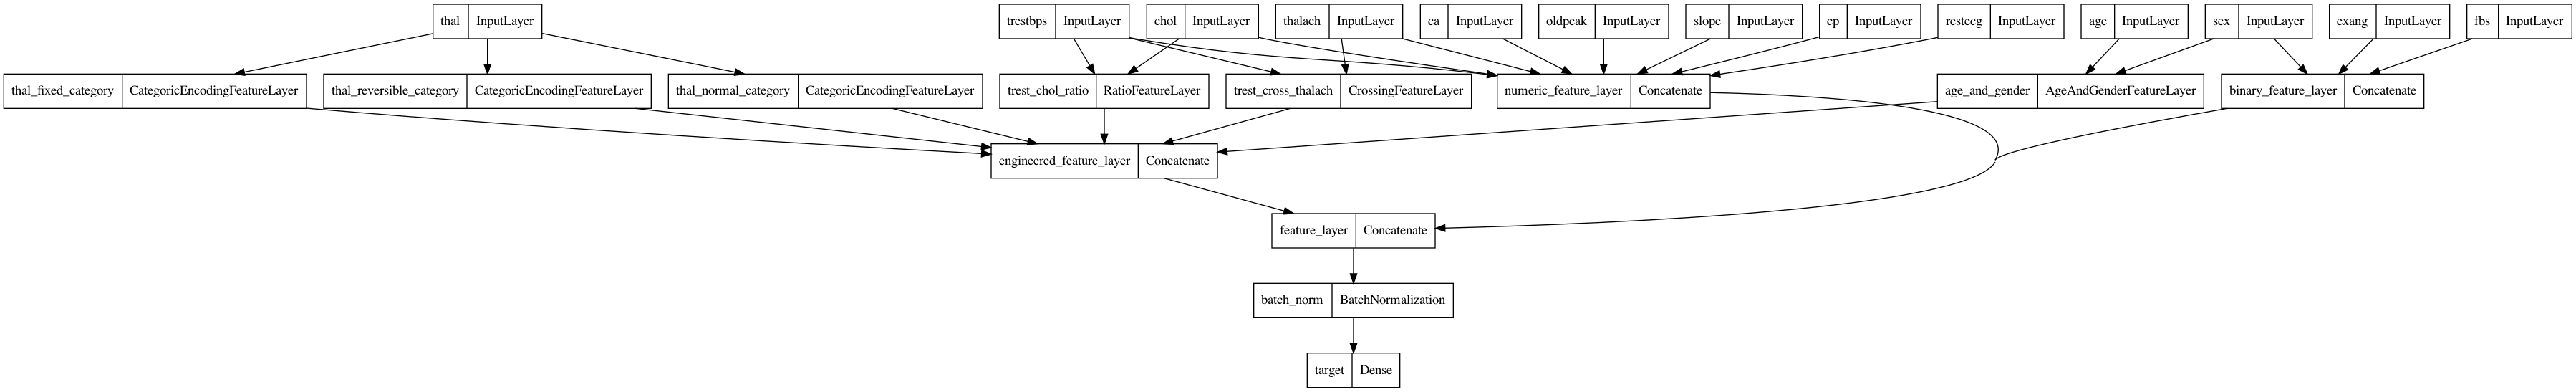

In [24]:
plot_model(model, to_file="full_model.png")

# Train Model and Save model

In [25]:
model.fit(dataset, epochs=10)

# save model
tf.keras.models.save_model(model, "lambda_layered_model")

2022-03-06 17:49:03.058537: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10
48/48 [==============================] - 1s 6ms/step - loss: 0.6126 - accuracy: 0.6538 - auc: 0.6484
Epoch 2/10
48/48 [==============================] - 0s 696us/step - loss: 0.3515 - accuracy: 0.8413 - auc: 0.9031
Epoch 3/10
48/48 [==============================] - 0s 646us/step - loss: 0.3218 - accuracy: 0.8578 - auc: 0.9200
Epoch 4/10
48/48 [==============================] - 0s 656us/step - loss: 0.3129 - accuracy: 0.8667 - auc: 0.9251
Epoch 5/10
48/48 [==============================] - 0s 645us/step - loss: 0.3121 - accuracy: 0.8650 - auc: 0.9254
Epoch 6/10
48/48 [==============================] - 0s 793us/step - loss: 0.3099 - accuracy: 0.8663 - auc: 0.9276
Epoch 7/10
48/48 [==============================] - 0s 655us/step - loss: 0.3071 - accuracy: 0.8627 - auc: 0.9291
Epoch 8/10
48/48 [==============================] - 0s 704us/step - loss: 0.3018 - accuracy: 0.8693 - auc: 0.9315
Epoch 9/10
48/48 [==============================] - 0s 705us/step - loss: 0.3046 - accurac

2022-03-06 17:49:04.469939: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: lambda_layered_model/assets


# Load model and predict on raw data

In [26]:
# load model for inference
loaded_model = tf.keras.models.load_model("lambda_layered_model")

In [27]:
dict(zip(loaded_model.metrics_names, loaded_model.evaluate(dataset)))

48/48 [==============================] - 0s 787us/step - loss: 0.2970 - accuracy: 0.8746 - auc: 0.9344


{'loss': 0.29703059792518616,
 'accuracy': 0.8745874762535095,
 'auc': 0.9343647360801697}